In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Import necessary modules for collaborative filtering
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Dropout, Add, Concatenate # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

from anime_sensei.utils.utility import read_file_from_S3, save_data_to_S3


In [2]:
clean_df = read_file_from_S3("Artifacts/Data_Cleaning/06-16-2025_20-05-59/Cleaned_Anime_Description.csv")
clean_df.head()

,anime_id,Name,Score,Genres,Synopsis,Type,Episodes,Rating,Popularity,Favorites,Scored By,Members,Image URL,Duration_mins
0,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24
1,5,Cowboy Bebop: Tengoku no Tobira,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,R - 17+ (violence & profanity),602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...,115
2,6,Trigun,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,PG-13 - Teens 13 or older,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...,24
3,7,Witch Hunter Robin,7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,PG-13 - Teens 13 or older,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...,25
4,8,Bouken Ou Beet,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,PG - Children,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...,23


In [3]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20370 entries, 0 to 20369
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   anime_id       20370 non-null  int64  
 1   Name           20370 non-null  object 
 2   Score          20370 non-null  float64
 3   Genres         20370 non-null  object 
 4   Synopsis       20370 non-null  object 
 5   Type           20370 non-null  object 
 6   Episodes       20370 non-null  float64
 7   Rating         20370 non-null  object 
 8   Popularity     20370 non-null  int64  
 9   Favorites      20370 non-null  int64  
 10  Scored By      20370 non-null  float64
 11  Members        20370 non-null  int64  
 12  Image URL      20370 non-null  object 
 13  Duration_mins  20370 non-null  int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 2.2+ MB


In [4]:
ratings_df = read_file_from_S3("Artifacts/Data_ingestion/06-14-2025_22-09-04/Anime_Ratings.csv")
ratings_df.head()

,user_id,Username,anime_id,Anime Title,rating
0,1,Xinil,21,One Piece,9
1,1,Xinil,48,.hack//Sign,7
2,1,Xinil,320,A Kite,5
3,1,Xinil,49,Aa! Megami-sama!,8
4,1,Xinil,304,Aa! Megami-sama! Movie,8


In [5]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24325191 entries, 0 to 24325190
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 927.9+ MB


In [6]:
ratings_df.shape

(24325191, 5)

In [7]:
anime_full = pd.merge(clean_df, ratings_df, on='anime_id',suffixes = ("_anime", "_user") ,how='inner')
anime_full.drop(['Anime Title'], axis=1, inplace = True)

In [8]:
anime_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24310872 entries, 0 to 24310871
Data columns (total 17 columns):
 #   Column         Dtype  
---  ------         -----  
 0   anime_id       int64  
 1   Name           object 
 2   Score          float64
 3   Genres         object 
 4   Synopsis       object 
 5   Type           object 
 6   Episodes       float64
 7   Rating         object 
 8   Popularity     int64  
 9   Favorites      int64  
 10  Scored By      float64
 11  Members        int64  
 12  Image URL      object 
 13  Duration_mins  int64  
 14  user_id        int64  
 15  Username       object 
 16  rating         int64  
dtypes: float64(3), int64(7), object(7)
memory usage: 3.3+ GB


In [9]:
anime_full.head()

,anime_id,Name,Score,Genres,Synopsis,Type,Episodes,Rating,Popularity,Favorites,Scored By,Members,Image URL,Duration_mins,user_id,Username,rating
0,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,1,Xinil,10
1,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,4,Crystal,8
2,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,20,vondur,9
3,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,23,Amuro,9
4,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,47,kei-clone,7


In [10]:
anime_full[['rating', 'Type', 'Episodes', 'Popularity', 'Favorites', 'Scored By', 'Duration_mins']].describe()

,rating,Episodes,Popularity,Favorites,Scored By,Duration_mins
count,2.431087e+07,2.431087e+07,2.431087e+07,2.431087e+07,2.431087e+07,2.431087e+07
mean,7.623484e+00,2.171993e+01,1.591526e+03,1.114631e+04,2.898992e+05,3.273713e+01
std,1.661239e+00,4.701637e+01,1.860237e+03,2.794053e+04,4.282439e+05,2.597712e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+00,3.000000e+00,2.950000e+02,1.970000e+02,3.739400e+04,2.300000e+01
50%,8.000000e+00,1.200000e+01,9.640000e+02,1.229000e+03,1.185360e+05,2.400000e+01
75%,9.000000e+00,2.400000e+01,2.204000e+03,7.765000e+03,3.453420e+05,2.500000e+01
max,1.000000e+01,3.057000e+03,2.470600e+04,2.176060e+05,2.660903e+06,1.680000e+02


In [12]:
anime_full.head()

,anime_id,Name,Score,Genres,Synopsis,Type,Episodes,Rating,Popularity,Favorites,Scored By,Members,Image URL,Duration_mins,user_id,Username,rating
0,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,1,Xinil,10
1,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,4,Crystal,8
2,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,20,vondur,9
3,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,23,Amuro,9
4,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,47,kei-clone,7


1. Neural Networks

In [13]:
## Encoding user IDs
user_encoder = LabelEncoder()
anime_full["user_encoded"] = user_encoder.fit_transform(anime_full["user_id"])
num_users = len(user_encoder.classes_)

## Encoding anime IDs
anime_encoder = LabelEncoder()
anime_full["anime_encoded"] = anime_encoder.fit_transform(anime_full["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))
print("Minimum rating: {}, Maximum rating: {}".format(min(anime_full['rating']), max(anime_full['rating'])))

Number of unique users: 270029, Number of unique anime: 15896
Minimum rating: 1, Maximum rating: 10


In [14]:
os.makedirs("./encoders", exist_ok=True)  # creates the folder if it doesn't exist
with open("./encoders/user_ratings_encoder.pkl", "wb") as f:
    pickle.dump(user_encoder, f)

with open("./encoders/anime_encoder.pkl", "wb") as f:
    pickle.dump(anime_encoder, f)

In [15]:
anime_full

,anime_id,Name,Score,Genres,Synopsis,Type,Episodes,Rating,Popularity,Favorites,Scored By,Members,Image URL,Duration_mins,user_id,Username,rating,user_encoded,anime_encoded
0,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,1,Xinil,10,0,0
1,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,4,Crystal,8,1,0
2,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,20,vondur,9,3,0
3,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,23,Amuro,9,4,0
4,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,R - 17+ (violence & profanity),43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,24,47,kei-clone,7,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24310867,55688,Baka Bakka,6.39,UNKNOWN,Music video for the original song Baka Bakka b...,Music,1.0,PG-13 - Teens 13 or older,20542,0,0.0,103,https://cdn.myanimelist.net/images/anime/1534/...,2,1238729,greebo,6,263123,15894
24310868,55720,Tensura × Genyoha,6.39,"Comedy, Fantasy",A collaboration anime between Genjitsu no Yoha...,ONA,0.0,PG-13 - Teens 13 or older,0,0,0.0,0,https://cdn.myanimelist.net/images/anime/1615/...,0,345829,Ricz,5,108064,15895
24310869,55720,Tensura × Genyoha,6.39,"Comedy, Fantasy",A collaboration anime between Genjitsu no Yoha...,ONA,0.0,PG-13 - Teens 13 or older,0,0,0.0,0,https://cdn.myanimelist.net/images/anime/1615/...,0,388105,Djisas,6,132342,15895
24310870,55720,Tensura × Genyoha,6.39,"Comedy, Fantasy",A collaboration anime between Genjitsu no Yoha...,ONA,0.0,PG-13 - Teens 13 or older,0,0,0.0,0,https://cdn.myanimelist.net/images/anime/1615/...,0,439150,play_thing,7,157356,15895


In [16]:
# Shuffle the dataset
anime_full = shuffle(anime_full, random_state=42)

# Create feature matrix X and target variable y
X = anime_full[['user_encoded', 'anime_encoded']].values
y = anime_full["rating"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (24310872, 2)
Shape of y: (24310872,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 17017610
Number of samples in the test set: 7293262


In [18]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [19]:
def RecommenderNet(num_users, num_animes, embedding_size=64, dropout_rate=0.3):
    # Inputs
    user_input = Input(shape=(1,), name='user_ratings_input')
    anime_input = Input(shape=(1,), name='anime_input')

    # Embeddings
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size,
                               name='user_ratings_embedding', embeddings_regularizer=l2(1e-6))(user_input)
    anime_embedding = Embedding(input_dim=num_animes, output_dim=embedding_size,
                                name='anime_embedding', embeddings_regularizer=l2(1e-6))(anime_input)

    # Bias terms
    user_bias = Embedding(input_dim=num_users, output_dim=1, name='user_ratings_bias')(user_input)
    anime_bias = Embedding(input_dim=num_animes, output_dim=1, name='anime_bias')(anime_input)

    # Dot product interaction
    dot_product = Dot(axes=-1)([user_embedding, anime_embedding])
    dot_product = Flatten()(dot_product)

    # Flatten biases
    user_bias = Flatten()(user_bias)
    anime_bias = Flatten()(anime_bias)

    # Sum all parts: dot + bias
    interaction = Add()([dot_product, user_bias, anime_bias])

    # Dense layers for deeper interaction
    dense = Dense(128, activation='relu')(interaction)
    dense = Dropout(dropout_rate)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    output = Dense(1, activation='linear')(dense)  # Predict raw score

    model = Model(inputs=[user_input, anime_input], outputs=output)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae', 'mse'])

    return model

def get_lr_callback(start_lr=1e-5, max_lr=5e-5, min_lr=1e-5, rampup_epochs=5, sustain_epochs=0, exp_decay=0.8):
    def lrfn(epoch):
        if epoch < rampup_epochs:
            return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            return max_lr
        else:
            return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr
    return LearningRateScheduler(lrfn, verbose=1)

def train_model(model, X_train_input, y_train, batch_size=10000, epochs=30, validation_split=0.1):
    # Callbacks
    checkpoint_path = './Weights/myanimeweights.weights.h5'
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=3,
        restore_best_weights=True
    )

    lr_scheduler = get_lr_callback()

    callbacks = [checkpoint, lr_scheduler, early_stopping]

    # Train
    history = model.fit(
        X_train_input,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

In [50]:
model = RecommenderNet(num_users, num_animes)

In [51]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_ratings_input  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_ratings_embed… │ (None, 1, 64)     │ 17,281,856 │ user_ratings_inp… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 64)     │  1,017,344 │ anime_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1, 1)      │          0 │ user_ratings_emb… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_ratings_bias   │ (None, 1, 1)      │    270,029 │ user_ratings_inp… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_bias          │ (None, 1, 1)      │     15,896 │ anime_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1)         │          0 │ dot_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1)         │          0 │ user_ratings_bia… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 1)         │          0 │ anime_bias[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1)         │          0 │ flatten_3[0][0],  │
│                     │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │        256 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,593,702 (70.93 MB)

 Trainable params: 18,593,702 (70.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model, history = train_model(model, X_train_array, y_train)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 104s 67ms/step - loss: 59.6299 - mae: 7.5398 - mse: 59.6150 - val_loss: 53.2062 - val_mae: 7.1021 - val_mse: 53.1922 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 104s 67ms/step - loss: 44.6328 - mae: 6.4307 - mse: 44.6191 - val_loss: 13.7586 - val_mae: 3.4132 - val_mse: 13.7455 - learning_rate: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 103s 67ms/step - loss: 8.0167 - mae: 2.3891 - mse: 8.0036 - val_loss: 2.6389 - val_mae: 1.2655 - val_mse: 2.6262 - learning_rate: 2.6000e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.4000000000000007e-05.
Epoch 4/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 102s 67ms/step - loss: 3.5092 - mae: 1.4744 - mse: 3.4966 - val_loss: 2.4120 - val_mae: 1.2028

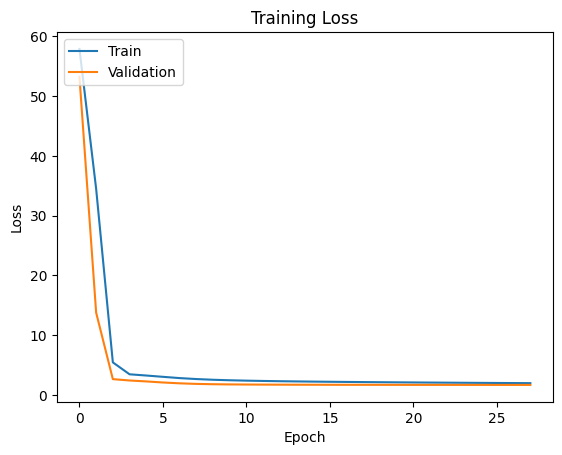

In [23]:
plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [24]:
evaluation = model.evaluate(X_test_array, y_test)
print(f"Test Loss: {evaluation[0]}, Test MAE: {evaluation[1]}, Test MSE: {evaluation[2]}")

227915/227915 ━━━━━━━━━━━━━━━━━━━━ 1297s 6ms/step - loss: 1.6712 - mae: 0.9784 - mse: 1.6571
Test Loss: 1.6711663007736206, Test MAE: 0.978275716304779, Test MSE: 1.6570816040039062


In [47]:
import numpy as np
import pandas as pd

def get_top_n_recommendations(model, user_id, anime_df, full_df, user_encoder, anime_encoder, N=10):
    # Check if user exists in encoder
    if user_id not in user_encoder.classes_:
        raise ValueError(f"User ID {user_id} not seen during training. Choose from: {user_encoder.classes_[:5]} ...")

    # Get internal encoded user ID
    encoded_user = user_encoder.transform([user_id])[0]

    # Animes the user has already rated
    watched_anime_ids = set(full_df[full_df['user_id'] == user_id]['anime_id'].values)

    # Filter unseen animes from metadata
    unseen_animes = anime_df[~anime_df['anime_id'].isin(watched_anime_ids)].copy()

    # Filter out any anime IDs the encoder wasn’t trained on
    unseen_animes = unseen_animes[unseen_animes['anime_id'].isin(anime_encoder.classes_)]
    if unseen_animes.empty:
        print(f"No unseen animes found for user {user_id}")
        return pd.DataFrame()

    # Encode anime IDs
    unseen_animes['anime_encoded'] = anime_encoder.transform(unseen_animes['anime_id'])

    # Create model inputs
    user_input = np.full(len(unseen_animes), encoded_user)
    anime_input = unseen_animes['anime_encoded'].values

    # Predict scores
    predicted_scores = model.predict([user_input, anime_input], batch_size=512, verbose=0).flatten()
    unseen_animes['predicted_rating'] = predicted_scores

    # Sort and get top-N
    top_n = unseen_animes.sort_values(by='predicted_rating', ascending=False).head(N)

    # Select useful columns for display
    return top_n[['anime_id', 'Name', 'Genres', 'Score', 'predicted_rating']]

In [52]:
model.load_weights("./Weights/myanimeweights.weights.h5")
print("✅ Weights successfully loaded.")

✅ Weights successfully loaded.


In [54]:
user_id = 1863  
top_animes = get_top_n_recommendations(
    model=model,
    user_id=user_id,
    anime_df=clean_df,
    full_df=anime_full,
    user_encoder=user_encoder,
    anime_encoder=anime_encoder,
    N=20
)

print("NEURAL NETWORKS: ")
top_animes

NEURAL NETWORKS: 


,anime_id,Name,Genres,Score,predicted_rating
3937,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy",9.10,9.937974
741,820,Ginga Eiyuu Densetsu,"Drama, Sci-Fi",9.02,9.877166
9632,28977,Gintama°,"Action, Comedy, Sci-Fi",9.06,9.672021
11260,32935,Haikyuu!! Karasuno Koukou vs. Shiratorizawa Ga...,Sports,8.78,9.667171
10949,32281,Kimi no Na wa.,"Award Winning, Drama, Supernatural",8.85,9.642323
25,44,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,"Action, Drama, Romance",8.71,9.621043
1393,1535,Death Note,"Supernatural, Suspense",8.62,9.610005
7133,15417,Gintama': Enchousen,"Action, Comedy, Sci-Fi",9.03,9.587157
8369,21939,Mushishi Zoku Shou,"Adventure, Mystery, Slice of Life, Supernatural",8.70,9.547317
16541,42938,Fruits Basket: The Final,"Drama, Romance, Supernatural",9.00,9.546021


In [31]:
def get_user_history(user_id, anime_df, ratings_df):
    # Filter ratings for the user
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    
    if user_ratings.empty:
        print(f"No history found for user {user_id}")
        return pd.DataFrame()

    # Merge with metadata to get anime titles and genres
    history = pd.merge(user_ratings, anime_df, on='anime_id', how='left')

    return history[['anime_id', 'Name', 'Genres', 'rating']].sort_values(by='rating', ascending=False)

In [36]:
user_history = get_user_history(
    user_id=1863,
    anime_df=clean_df,
    ratings_df=anime_full[['user_id', 'anime_id', 'rating']]  # or original ratings_df if preferred
)
user_history.head(20)

,anime_id,Name,Genres,rating
0,329,Planetes,"Award Winning, Drama, Romance, Sci-Fi",10
189,2158,Terra e... (TV),"Action, Drama, Sci-Fi",10
183,2418,Stranger: Mukou Hadan,"Action, Adventure",10
176,1195,Zero no Tsukaima,"Action, Adventure, Comedy, Fantasy, Romance, E...",10
147,1698,Nodame Cantabile,"Comedy, Romance",10
41,6,Trigun,"Action, Adventure, Sci-Fi",10
45,2001,Tengen Toppa Gurren Lagann,"Action, Adventure, Award Winning, Sci-Fi",10
137,81,Kidou Senshi Gundam: Dai 08 MS Shoutai,"Adventure, Drama, Romance, Sci-Fi",10
47,857,Air Gear,"Action, Ecchi",10
49,330,Midori no Hibi,"Comedy, Drama, Romance, Ecchi",10


2. SVD

In [39]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# Use only these three columns
df = anime_full[['user_id', 'anime_id', 'rating']].copy()

# Define reader with rating scale
reader = Reader(rating_scale=(df.rating.min(), df.rating.max()))

# Load data into Surprise format
data = Dataset.load_from_df(df, reader)
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

In [55]:
svd_model = SVD(n_factors=100, biased=True, verbose=True)
svd_model.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [56]:
predictions = svd_model.test(testset)
print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))

RMSE: 1.2458
RMSE: 1.2457594970127563
MAE:  0.9187
MAE: 0.918727101584249


In [58]:
with open('./models/svd_with_trainset.pkl', 'wb') as f:
    pickle.dump({'model': svd_model, 'trainset': trainset}, f)

In [59]:
def get_svd_recommendations(model, user_id, anime_df, full_df, N=10):
    # Get all anime IDs
    all_animes = set(anime_df['anime_id'].unique())
    watched = set(full_df[full_df['user_id'] == user_id]['anime_id'].values)
    unseen = list(all_animes - watched)

    # Predict ratings for unseen animes
    predictions = [model.predict(user_id, aid) for aid in unseen]
    top_preds = sorted(predictions, key=lambda x: x.est, reverse=True)[:N]

    # Get details from metadata
    top_anime_ids = [pred.iid for pred in top_preds]
    top_df = anime_df[anime_df['anime_id'].isin(top_anime_ids)][['anime_id', 'Name', 'Genres', 'Score']]

    # Attach predicted scores
    est_dict = {pred.iid: pred.est for pred in top_preds}
    top_df['predicted_rating'] = top_df['anime_id'].map(est_dict)

    return top_df.sort_values(by='predicted_rating', ascending=False)

In [ ]:
recommendations = get_svd_recommendations(svd_model, user_id=186 3, anime_df=clean_df, full_df=anime_full, N=20)
recommendations

,anime_id,Name,Genres,Score,predicted_rating
203,227,FLCL,"Action, Avant Garde, Comedy, Sci-Fi",8.03,10.000000
871,966,Crayon Shin-chan,"Comedy, Ecchi",7.77,10.000000
1720,1889,Higurashi no Naku Koro ni Kai,"Mystery, Supernatural, Suspense",8.18,10.000000
3022,3457,Vampire Knight,"Drama, Mystery, Romance, Supernatural",6.88,10.000000
5800,9756,Mahou Shoujo Madoka★Magica,"Award Winning, Drama, Suspense",8.36,9.996416
239,263,Hajime no Ippo,Sports,8.76,9.941994
5062,7724,Shiki,"Horror, Mystery, Supernatural, Suspense",7.73,9.899161
5150,8074,Highschool of the Dead,"Action, Horror, Supernatural, Ecchi",7.07,9.899104
10949,32281,Kimi no Na wa.,"Award Winning, Drama, Supernatural",8.85,9.830661
15254,40010,Ishuzoku Reviewers,"Comedy, Fantasy, Ecchi",7.43,9.808974


In [61]:
set(top_animes['anime_id']) & set(recommendations['anime_id'])

{5114, 32281}